We are going to try to analyze the diabetic data set to draw some insights on the data that we have and then train a machine learning algorithm to try to predict whether a person is going to be diabetic or not based on the parameters given here. 


In [23]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.api as sm
from statsmodels.genmod import families
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import GridSearchCV
import seaborn as sns


In [24]:
#reading in the file of interest
diabeats= pd.read_csv('/Users/Godfred King/Desktop/Python/diabetes/diabetes.csv')

diabeats_ml= diabeats.copy()
diabeats.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Bias which represents overestimation or underestimation of a prediction is accounted for with the constant term. The constant term is added so that the residual value which is the difference between the true value and the predicted value is always 0. This will then reduce bias in our model.

In [25]:
#Adding a constant term to the dataframe
diabeats= sm.add_constant(diabeats, prepend=False)
diabeats.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,const
0,6,148,72,35,0,33.6,0.627,50,1,1.0
1,1,85,66,29,0,26.6,0.351,31,0,1.0
2,8,183,64,0,0,23.3,0.672,32,1,1.0
3,1,89,66,23,94,28.1,0.167,21,0,1.0
4,0,137,40,35,168,43.1,2.288,33,1,1.0


Text(0.5, 1.0, 'Age Distribution')

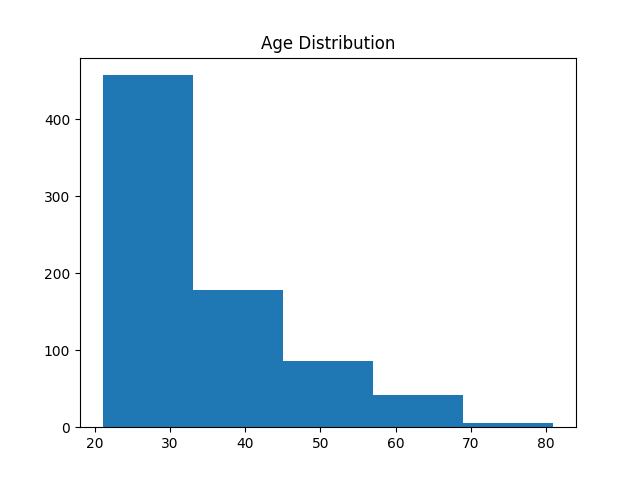

In [26]:
plt.figure()
plt.hist(diabeats['Age'],bins=5)
plt.title('Age Distribution')

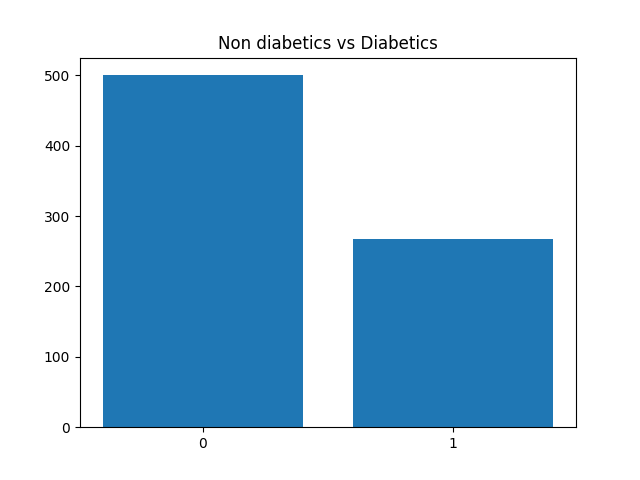

In [47]:
height=dict(diabeats['Outcome'].value_counts())
x_vals= list(height.keys())
level= list(height.values())
plt.figure()
plt.bar(x_vals,level)
plt.title('Non diabetics vs Diabetics')
plt.xticks([0,1]);



We want to investigate to find out whether for all of the parameters, there was any significant difference in means between the the non-diabetics and the diabetics. 


In [28]:
#Checking the data for the normality distribution 
dvs=list(diabeats.columns)[:len(diabeats.columns)-2]
normality_dict={}
for var in dvs:
    normality_dict[var]=stats.shapiro(diabeats[var])
normality_dict
normality_df= pd.DataFrame(normality_dict)
normality_df=normality_df.T\
    .rename({0:'Shapiro Stat',1:'p_val'}, axis=1)

normality_df['distribution']= normality_df['p_val'].apply(lambda x:'Normally distributed' if x>0.05 else 'Not normally distributed')
normality_df

,Shapiro Stat,p_val,distribution
Pregnancies,0.904278,1.608089e-21,Not normally distributed
Glucose,0.970104,1.986761e-11,Not normally distributed
BloodPressure,0.818921,1.584007e-28,Not normally distributed
SkinThickness,0.904627,1.751576e-21,Not normally distributed
Insulin,0.722021,7.915248e-34,Not normally distributed
BMI,0.949989,1.840562e-15,Not normally distributed
DiabetesPedigreeFunction,0.836519,2.477697e-27,Not normally distributed
Age,0.874766,2.401947e-24,Not normally distributed


A shapiro-wilk test for normality shows that none of the parameters are normally distributed with the p_val for all of the parameters being less than 0.05. We are going to use Mann-Whitney U test

In [29]:
mannu_dict={}
for var in dvs:
    mannu_dict[var]= stats.mannwhitneyu(diabeats[var], diabeats['Outcome'])


mannu_df= pd.DataFrame(mannu_dict)
mannu_df= mannu_df.T\
    .rename({0:'Mann-Whitney test statistic',1:'p_val'},axis=1)
mannu_df['significance']= mannu_df['p_val'].apply(lambda x:'Significant' if x<0.05 else 'Not significant')
mannu_df

,Mann-Whitney test statistic,p_val,significance
Pregnancies,514236.0,8.403784e-153,Significant
Glucose,587234.0,1.913281e-258,Significant
BloodPressure,571694.0,1.333994e-233,Significant
SkinThickness,472238.0,7.152017e-104,Significant
Insulin,396092.0,3.022779e-38,Significant
BMI,584126.0,2.345315e-253,Significant
DiabetesPedigreeFunction,397668.0,1.621715e-33,Significant
Age,589824.0,8.435337e-263,Significant


The Mann-Whitney test showed that for all of the parameters there was a significant mean difference between the diabetics and non- diabetics. 

Trying to test for the main assumptions of Logistics Regression
1. The dependent variable should be binary
2. The data should be independent. That each row should represent one datapoint
3. The data should exhibit little to no multicolinearity. That is the independent variables should be independent of each other.(0.7 correlation between two variables typically will represent too strong a correlation and just one of those variables ideally should be used for the predictive model)(Checked for this assumption using Variance inflation factor rather)
4. The continuous independent variables should have a linear relationship with the log odds of the dependent variables. 
5. There should not be outliers and also the dataset should be relatively large >500
6. There should not be any significant outliers in the data. 

In [30]:
#Binary logistic regression 
u_vals=list(diabeats['Outcome'].unique())
print('The unique values in the datasets are {} and {}. The first assumption has been met'. format(u_vals[0], u_vals[1]))

The unique values in the datasets are 1 and 0. The first assumption has been met


In [31]:
#Each data point should be independent representing a single datapoint 
diabeats.head(4)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,const
0,6,148,72,35,0,33.6,0.627,50,1,1.0
1,1,85,66,29,0,26.6,0.351,31,0,1.0
2,8,183,64,0,0,23.3,0.672,32,1,1.0
3,1,89,66,23,94,28.1,0.167,21,0,1.0


The data shows that each row represents a single datapoint. One of the participants in each row

In [32]:
#Checking for the multicolinearity of the explanatory variables
independent_vars= diabeats[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age','const']]

       
def calc_vif(df):
    '''Calculates the Variance inflation factor for the particular column.
    Returns a dataframe with the VIF for each of the columns
    '''
    vif_df= pd.DataFrame()
    vif_df['Independent Variable']= df.columns
    vif_df['VIF index']= [vif(df.values,i )for i in range(df.shape[1])]

    return (vif_df)
    

calc_vif(independent_vars)

,Independent Variable,VIF index
0,Pregnancies,1.430872
1,Glucose,1.298961
2,BloodPressure,1.181863
3,SkinThickness,1.507432
4,Insulin,1.427536
5,BMI,1.297450
6,DiabetesPedigreeFunction,1.067090
7,Age,1.588368
8,const,35.039974


The results show that no multicolinearity exist between the independent variables because all of the Variance Inflation Factor index is below 5 and actually very close to 1.

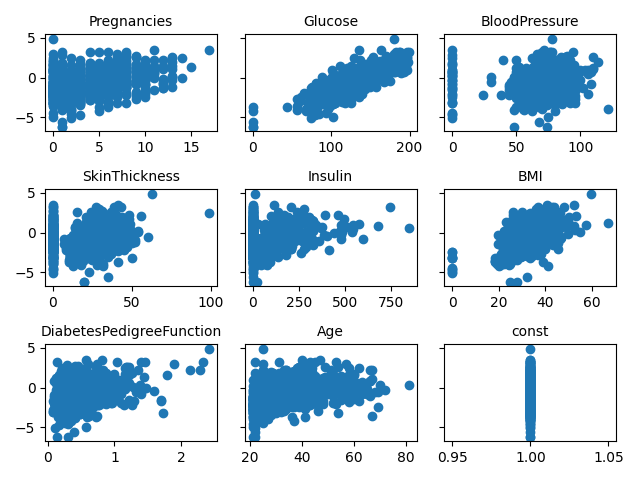

In [33]:
#Checking for the assumption that independent variables show have a linear relationship with logodds of the dependent variables
log_results= GLM(diabeats['Outcome'],independent_vars, family=families.Binomial()).fit()
prediction= log_results.predict(independent_vars)
log_odds= np.log((prediction*1.0)/(1-prediction))
log_odds

fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9))= plt.subplots(3,3, sharey=True,tight_layout=True)
inde_list=list(independent_vars.columns)

fig_axes=list(fig.axes)
for ax in fig_axes:
    idx= fig_axes.index(ax)
    ax.scatter(independent_vars[inde_list[idx]],log_odds)
    
    ax.set_title(inde_list[idx],size=10)

    


inde_list.remove('const')



Checking for the presence of influential outliers using the Cook's distance.
A good rule of thumbs is that the datapoints which are above the Cook distance threshold are influential. The cook's distance threshold is calculated as 4/(length of the dataframe)
* We are going to plot a scatter plot to show the cook's distance for every datapoint in the data and then draw the threshold on the scatter plot to clearly indicate the points which are above the threshold.

Text(0.5, 1.0, 'Cooks Distance each Datapoint')

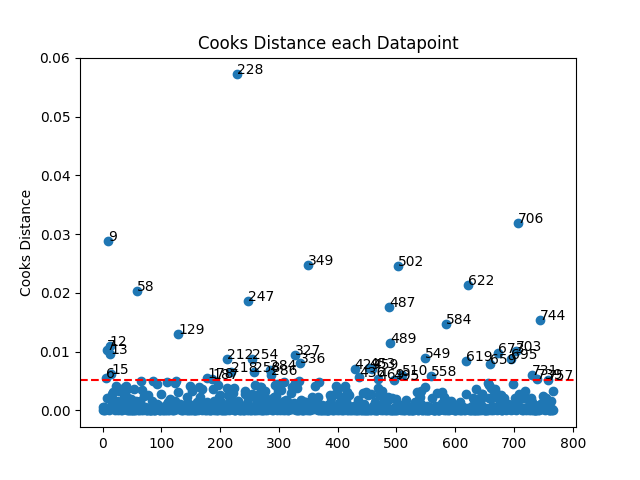

In [34]:
#This is the way to prevent scientific notation from being printed out 
np.set_printoptions(suppress=True)
influence=log_results.get_influence()
cooks_distance= influence.cooks_distance
cooks_df= pd.DataFrame(cooks_distance).T\
    .rename({0:'Cooks Distance',1:'p_value'},axis=1)



cook_threshold= 4/len(cooks_df)

plt.figure()
plt.scatter(cooks_df.index, cooks_df['Cooks Distance'])

for i in range(len(cooks_df)):
    if cooks_df.iloc[i]['Cooks Distance']> cook_threshold:
        plt.annotate(cooks_df.index[i], (cooks_df.index[i], cooks_df.iloc[i]['Cooks Distance']))

plt.axhline(y=cook_threshold, ls='--',c ='red')
plt.ylabel('Cooks Distance')
plt.title('Cooks Distance each Datapoint')

Although there are some points visibly above the Cook's distance threshold for this data. The highest threshold is around 0.06 for index 228. Cook's distance greater than 
0.5 are considered to be very influential. As such none of the datapoints will be dropped. 

The Box-Tidwell test cannot be implemented for this dataset due to the presence of 0 in the independent variables. THe test requires a log transformation of the values and log(0) is undefined. Therefore the only way to check for this assumption is to build the scatter plot.

In [35]:
#Performing of the Box-Tidwell test
# btt_df= diabeats.copy()
# ind_vars= list(independent_vars.columns)
# ind_vars.remove('const')
# ind_vars
# for var in ind_vars:
#     btt_df['log_{}'.format(var)]=btt_df[var].apply(lambda x: x*np.log(x))
# btt_df= btt_df.where()
# log_results= GLM(diabeats['Outcome'],btt_df, family= families.Binomial()).fit()
# log_results.summary()

It almost feels like the 0 was used to replace the Null values but I think they are influencing the model performance in a way because they are a lot and also a person with blooc pressure reading of 0 is practically dead and it also does not make sense to have a skin thickness of 0 or an insulin level of 0.
1. The issue here is replacing the 0s with the median or mean will also skew the model and might leading to overfitting with the training data and poor model performance on real life dataset
2. Removing those columns is not a good option because from diabetes is all about the insulin
3. Logistic Regression requires a large dataset typically >500 and the current dataset we have is 768 and so we are going to remove the rows with the zeros and then check again.
4. Removing those datapoints did not work either because of the number of rows with 0s in the independent variables 



In [36]:
# diabeats_ml=diabeats_ml[diabeats_ml['Insulin'] !=0]
# diabeats_ml

Due to the dependent variables are being on the different scale, we are going to normalize the data so there will be precise attribution of weights for the prediction of the dependent variables. 

Plan for Building of the model
1. Build a base model
2. Perform normalization on the independent variables
3. Perform regularization of the independent variables
4. Use Cross validation for the splitting of the data
5. Optimize the Logistic Regression inputs with Gridsearch 
6. Check the Model AUC score and show the ROC curve
7. Just for the fun of it, check the R squared value

In [37]:

X_train, X_test, y_train, y_test= train_test_split(diabeats_ml[inde_list], diabeats_ml['Outcome'], random_state=3, test_size=0.33)



In [38]:
# #Normalization of the independent variables
# scaler= MinMaxScaler()
# X_train_transform= scaler.fit_transform(X_train)
# X_test_transform = scaler.transform(X_test)

# X_train_transform


In [39]:
#Normalization of the independent variables using the StandardSCaler
scaler=StandardScaler()
X_train_transform= scaler.fit_transform(X_train)
X_test_transform= scaler.transform(X_test)

In [40]:
#Building of the base model
logreg= LogisticRegression()
logreg.fit(X_train,y_train)
prediction= logreg.predict(X_test)


c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This is the confusion matrix for the base Model
 [[133  15]
 [ 45  61]]
The AUC score for the base model is 0.7370601733809281


Text(0.5, 1.0, 'Confusion Matrix for the Base Model')

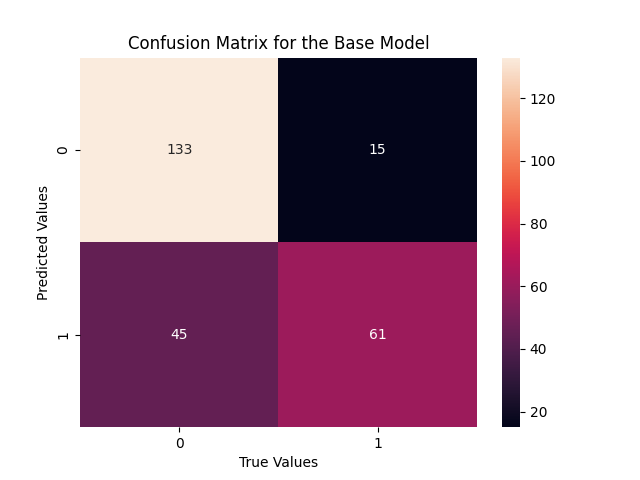

In [41]:
confusion= confusion_matrix(y_test, prediction)
auc_score= roc_auc_score(y_test, prediction)
print('This is the confusion matrix for the base Model\n', confusion)
print('The AUC score for the base model is {}'.format(auc_score))

plt.figure()
sns.heatmap(confusion, annot=True,fmt='g')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix for the Base Model')

We are now going to use gridsearch to optimize the hyperparameters for the regression model alogorithm to find the ideal values and the best scores. 

In [42]:
logreg= LogisticRegression(max_iter=250)
params= {'C':np.logspace(-4,4,10), 'penalty':['l2']}

gridsearch= GridSearchCV(logreg, param_grid=params, scoring='roc_auc')
gridsearch.fit(X_train_transform, y_train)

print('The best parameters for fitting the model are {}'. format(gridsearch.best_params_))
print('The highest AUC score that was obtained with the hypertuned parameters is ', gridsearch.best_score_)

The best parameters for fitting the model are {'C': 0.3593813663804626, 'penalty': 'l2'}
The highest AUC score that was obtained with the hypertuned parameters is  0.8226915660630449


There was no significant difference in the AUC score between the transformed and non-transformed data for the training and testing.

In [43]:
grid_predict= gridsearch.decision_function(X_test_transform)

auc_score= roc_auc_score(y_test, grid_predict)
print (auc_score)

0.838985211626721


In [44]:
logreg= LogisticRegression(C= 0.3593813663804626, penalty= 'l2').fit(X_train_transform, y_train)
prediction= logreg.decision_function(X_test_transform)

logs_score=logreg.score(X_test_transform,y_test)
log_auc_score= roc_auc_score(y_test, prediction)
print('Log score: ', logs_score)
print('Area under the curve score using the roc_auc_score function: ', log_auc_score)


Log score:  0.7637795275590551
Area under the curve score using the roc_auc_score function:  0.838985211626721


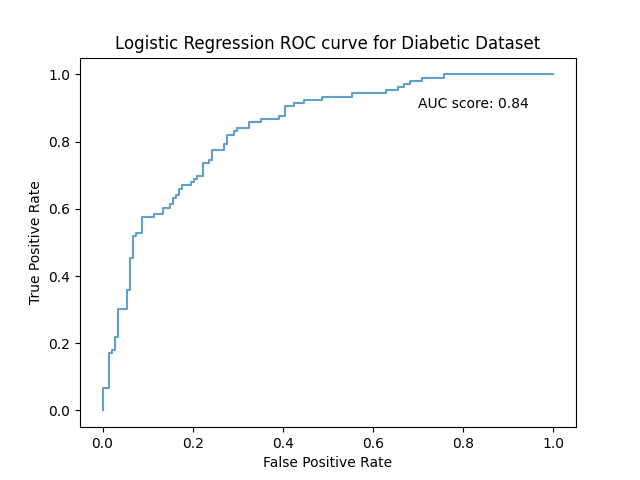

In [45]:
#Plotting the ROC curve and showing the AUC score


fpr, tpr,_ = roc_curve(y_test, prediction)
auc_sc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC curve for Diabetic Dataset')
plt.annotate('AUC score: {:.2f}'.format(auc_sc),(0.7,0.9));

